In [139]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

raw = pd.read_csv('trump.nicknames.wikipedia.csv')

raw.head()

,fake,real,notes,category
0,Dumbo[5],"Randolph ""Tex"" Alles",Director of the United States Secret Service,domestic political figures
1,Where's Hunter[6],Hunter Biden,American lawyer and lobbyist who is the second...,domestic political figures
2,1%[7] / Basement[8] / Beijing[9] / China[10] /...,Joe Biden,47th vice president of the United States; form...,domestic political figures
3,Little Michael Bloomberg[19] / Mini Mike[20] /...,Michael Bloomberg,108th Mayor of New York City; 2020 Democratic ...,domestic political figures
4,Da Nang Richard[22] / Da Nang Dick[23],Richard Blumenthal,U.S. senator from Connecticut; 23rd attorney g...,domestic political figures


# First look

The first thing I notice is that the fake names have reference numbers next to them, and are listed together. So let's create a single row for each fake name, and clean up both fake and real names for any special characters, and bring them to lowercase. We can however leave some characters to see how the model handels them, as this adds context in a name such as "Where's Hunter" shown in the head.

In [83]:
def clean(name):
    '''cleans the given name of special chs and lowers'''
    # deletes reference tag and lowers
    name = name[0:name.find('[')].lower()
    # keeps any values inside the []
    return re.sub(r"[^a-z0-9%'.-]", " ", name)

def get_row(fake, row):
    '''takes info and reproduces a row'''
    i, f, real, notes, category = row
    return {
        "fake name": clean(fake),
        "real name": str(real).lower(),
        "len fake": len(fake.split(' ')),
        "len real": len(real.split(' ')),
        "category": str(category),
        "notes": str(notes).lower()
    }

cleanDF = pd.DataFrame([get_row(fake, row) # returns dictionary obj
                        for row in raw.itertuples()
                        for fake in str(row[1]).split('/')])

cleanDF.head()
    

,fake name,real name,len fake,len real,category,notes
0,dumbo,"randolph ""tex"" alles",1,3,domestic political figures,director of the united states secret service
1,where's hunter,hunter biden,2,2,domestic political figures,american lawyer and lobbyist who is the second...
2,1%,joe biden,1,2,domestic political figures,47th vice president of the united states; form...
3,basement,joe biden,2,2,domestic political figures,47th vice president of the united states; form...
4,beijing,joe biden,2,2,domestic political figures,47th vice president of the united states; form...


As we can see with the head, most special characters are removed, everything is lowercase, and should be ready for training. I also added two columns for the word length of the fake and real names. Let's start by taking a look at the length comparisons.

# Comparing lengths of nicknames and real names 

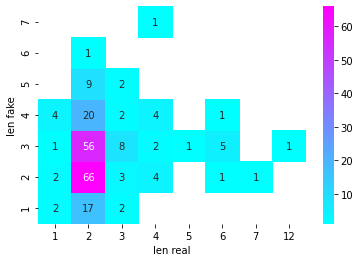

In [135]:
cleanDF['count'] = 1
counts = cleanDF.groupby(['len real', 'len fake']).agg({'count':'count'}).reset_index()

ax = sns.heatmap(counts.pivot_table(columns='len real', index='len fake', values='count'), annot=True, cmap='cool')
ax.invert_yaxis()

FIX UP CHART
------------------------------------------------
Awesome, now we can clearly see the relations between the length of the real names and length of the fake names! We see a trend to add words for real names with less than or equal to 3 words.

Next lets dive into our text! We should just get the word counts for real and fake names, to get a sense of what our wordbank is going to look like. I am worried there might not be enough words to generate a lot of different names.



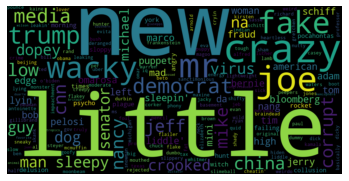

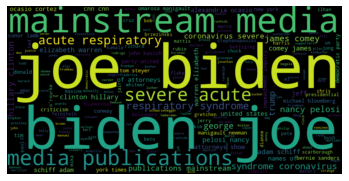

In [153]:
fake_words = " ".join([word for name in cleanDF['fake name'] for word in name.split(' ')])

wordcloud = WordCloud(width=1200, height=600, margin=0).generate(fake_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

real_words = " ".join([word for name in cleanDF['real name'] for word in name.split(' ')])

wordcloud = WordCloud(width=1200, height=600, margin=0).generate(real_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

The wordclouds seem to be repeating themselves, such as the double occurance of "joe" and "biden" on the second graph. This needs to be fixed

In [150]:
df1 = (cleanDF['real name'].str.split(expand=True)
              .stack()
              .value_counts()
              .rename_axis('vals')
              .reset_index(name='count'))

df1

,vals,count
0,joe,17
1,biden,13
2,the,9
3,of,8
4,james,8
...,...,...
242,nation,1
243,rahim,1
244,hewson,1
245,glenn,1
